In [1]:
import pandas as pd
import rasterio
from matplotlib import pyplot as plt

Pobranie i wczytanie do ramki pandas listy scen Landsata. Duży plik, ok. 20 MB.

In [2]:
google_scenes = pd.read_csv('https://storage.googleapis.com/gcp-public-data-landsat/index.csv.gz', compression='gzip')

In [3]:
google_scenes.head()

SCENE_ID                                PRODUCT_ID  \
0  LE71800592011134ASN00  LE07_L1TP_180059_20110514_20161209_01_T1   
1  LT51360422008226BKT00  LT05_L1GS_136042_20080813_20161030_01_T2   
2  LE71760312020339NSG00  LE07_L1TP_176031_20201204_20201230_01_T1   
3  LE71930302019087NSG00  LE07_L1TP_193030_20190328_20190423_01_T1   
4  LM10420361973161AAA05  LM01_L1TP_042036_19730610_20180428_01_T2   

  SPACECRAFT_ID SENSOR_ID DATE_ACQUIRED  COLLECTION_NUMBER  \
0     LANDSAT_7       ETM    2011-05-14                  1   
1     LANDSAT_5        TM    2008-08-13                  1   
2     LANDSAT_7       ETM    2020-12-04                  1   
3     LANDSAT_7       ETM    2019-03-28                  1   
4     LANDSAT_1       MSS    1973-06-10                  1   

  COLLECTION_CATEGORY                  SENSING_TIME DATA_TYPE  WRS_PATH  \
0                  T1  2011-05-14T08:50:07.5251363Z      L1TP       180   
1                  T2  2008-08-13T04:03:49.0450690Z      L1GS       136   
2                  T1  2020-12-04T07:41:11.6084536Z      L1TP       176   
3                  T1  2019-03-28T09:57:50.8833259Z      L1TP       193   
4                  T2  1973-06-10T17:50:11.5000000Z      L1TP        42   

   WRS_ROW  CLOUD_COVER  NORTH_LAT  SOUTH_LAT   WEST_LON   EAST_LON  \
0       59         74.0    2.39913    0.50961   18.09062   20.24870   
1       42         92.0   26.94950   25.03915   91.40541   93.81099   
2       31          3.0   42.75649   40.79350   33.66313   36.65653   
3       30          1.0   44.17399   42.20768    7.88666   10.97109   
4       36         11.0   35.71970   33.79417 -116.97493 -114.47118   

   TOTAL_SIZE                                           BASE_URL  
0   181281962  gs://gcp-public-data-landsat/LE07/01/180/059/L...  
1   141994748  gs://gcp-public-data-landsat/LT05/01/136/042/L...  
2   188511155  gs://gcp-public-data-landsat/LE07/01/176/031/L...  
3   154211367  gs://gcp-public-data-landsat/LE07/01/193/030/L...  
4    27823097  gs://gcp-public-data-landsat/LM01/01/042/036/L...

Wybór sceny o określonych kryteriach; "współrzędne" zdjęcia (path,row) , wybór tylko zdjęć T2, R2 (po korektach), z Landsata 8

In [5]:
path=189
row= 25
data_od = "2017-01-01"
data_do = "2019-06-01"
satelita = "LANDSAT_8"
limit_zachmurzenia = 10

scenes = google_scenes[(google_scenes.WRS_PATH == path) & (google_scenes.WRS_ROW == row) &
                    (google_scenes.DATE_ACQUIRED >= data_od) &
                    (google_scenes.DATE_ACQUIRED <= data_do) &
                    (google_scenes.CLOUD_COVER <= limit_zachmurzenia) & 
                    (google_scenes.SPACECRAFT_ID==satelita) &
                    (~google_scenes.PRODUCT_ID.str.contains('_T2')) &
                    (~google_scenes.PRODUCT_ID.str.contains('_RT'))]
    
print(' Znaleziono {} scen\n'.format(len(scenes)))

 Znaleziono 2 scen



Wybór sceny o najmniejszym zachmurzeniu:

In [7]:
best_scene = scenes.sort_values('CLOUD_COVER').iloc[0]
best_scene


SCENE_ID                                           LC81890252017173LGN00
PRODUCT_ID                      LC08_L1TP_189025_20170622_20170630_01_T1
SPACECRAFT_ID                                                  LANDSAT_8
SENSOR_ID                                                       OLI_TIRS
DATE_ACQUIRED                                                 2017-06-22
COLLECTION_NUMBER                                                      1
COLLECTION_CATEGORY                                                   T1
SENSING_TIME                                2017-06-22T09:38:22.4421660Z
DATA_TYPE                                                           L1TP
WRS_PATH                                                             189
WRS_ROW                                                               25
CLOUD_COVER                                                         3.37
NORTH_LAT                                                       51.40163
SOUTH_LAT                                          

In [8]:
best_scene.BASE_URL

'gs://gcp-public-data-landsat/LC08/01/189/025/LC08_L1TP_189025_20170622_20170630_01_T1'

Przetwarzanie adresu z usługi Google Cloud (protokół gs://) na obraz konkretnego pasma (band) dostępnego przez protokół https://

In [9]:
band = 'B4'
url = best_scene.BASE_URL
print(url)
url = url[5:]
print(url)
url = url + "/" + url[-40:] + "_" + band + ".TIF"
print(url)
url = 'https://storage.googleapis.com/' +url
print(url)

gs://gcp-public-data-landsat/LC08/01/189/025/LC08_L1TP_189025_20170622_20170630_01_T1
gcp-public-data-landsat/LC08/01/189/025/LC08_L1TP_189025_20170622_20170630_01_T1
gcp-public-data-landsat/LC08/01/189/025/LC08_L1TP_189025_20170622_20170630_01_T1/LC08_L1TP_189025_20170622_20170630_01_T1_B4.TIF
https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/189/025/LC08_L1TP_189025_20170622_20170630_01_T1/LC08_L1TP_189025_20170622_20170630_01_T1_B4.TIF


Pobieranie i otwieranie ratra za pomocą rasterio (por. zajęcia M. Kania)

In [10]:
with rasterio.open(url) as src:
    landsat = src.read(1)
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 8051, 'height': 8151, 'count': 1, 'crs': CRS.from_epsg(32634), 'transform': Affine(30.0, 0.0, 193785.0,
       0.0, -30.0, 5694915.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


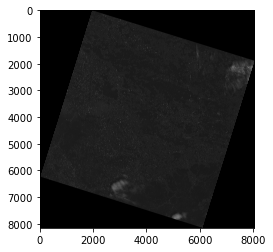

In [13]:
plt.imshow(landsat,cmap='gray')
